# Prototype Financial Planner

In [63]:
import os
import requests
import pandas as pd
from dotenv import load_dotenv
from alpaca_trade_api.rest import REST, TimeFrame
import numpy as np
from MCForecastTools import MCSimulation
import json
import re
from utils import find_crypto_value, calc_start_date
from datetime import date, time


load_dotenv()

True

## Part 1 - Personal Finance Planner
---
### Collect Crypto Prices Using the **requests** library

In [64]:
# We will use default crypto values of 1.2 BTC and 5.3 ETH
my_btc = 1.2
my_eth = 5.3

# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/"

# Store and parse crypto data from alternative.me free API
btc_response = requests.get(btc_url)
btc_data = btc_response.json()
eth_response = requests.get(eth_url)
eth_data = eth_response.json()

In [65]:
my_btc_value = find_crypto_value(my_btc, btc_data, 2)
my_eth_value = find_crypto_value(my_eth, btc_data, 2)
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $50446.80
The current value of your 5.3 ETH is $222806.70


### Collect Investments Data Using Alpaca: SPY (stocks) and AGG (bonds)

In [66]:
# Set user share totals for SPY and AGG
my_spy = 50
my_agg = 200

In [67]:
# Set Alpca API key and secret key, then insantiate an API object
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECURITY_KEY")

tradeapi = REST(alpaca_api_key, alpaca_secret_key, api_version='v2')


In [68]:
def get_company(ticker, start, end, tradeapi):
    return tradeapi.get_bars(
        ticker,
        TimeFrame.Day,
        start,
        end
    ).df

In [72]:
my_df = {
    "SPY":get_company("SPY", "2022-01-01", "2022-03-18", tradeapi),
    "AGG":get_company("AGG", "2022-01-01", "2022-03-18", tradeapi)
}

In [73]:
full_data = pd.concat(my_df.values(), keys=my_df.keys(), axis="columns")
full_data.head()


SPY                                       \
                             open    high       low   close     volume   
timestamp                                                                
2022-01-03 05:00:00+00:00  476.28  477.85  473.8500  477.71   72859933   
2022-01-04 05:00:00+00:00  479.26  479.98  475.5800  477.55   72130318   
2022-01-05 05:00:00+00:00  477.25  477.98  468.2801  468.38  104334251   
2022-01-06 05:00:00+00:00  468.00  470.82  465.4300  467.94   86899217   
2022-01-07 05:00:00+00:00  468.11  469.20  464.6500  466.09   84914433   

                                                      AGG                     \
                          trade_count        vwap    open      high      low   
timestamp                                                                      
2022-01-03 05:00:00+00:00      534806  476.520945  113.66  113.6753  113.300   
2022-01-04 05:00:00+00:00      565261  477.865001  113.20  113.3000  113.075   
2022-01-05 05:00:00+00:00      786612  473.232345  113.35  113.3600  112.900   
2022-01-06 05:00:00+00:00      803299  468.482337  112.75  112.8400  112.660   
2022-01-07 05:00:00+00:00      623751  466.942032  112.70  112.7050  112.340   

                                                                    
                            close   volume trade_count        vwap  
timestamp                                                           
2022-01-03 05:00:00+00:00  113.30  9398873       30228  113.467418  
2022-01-04 05:00:00+00:00  113.29  7769088       31298  113.183583  
2022-01-05 05:00:00+00:00  112.94  8530692       26843  113.092557  
2022-01-06 05:00:00+00:00  112.82  8859820       24721  112.771554  
2022-01-07 05:00:00+00:00  112.49  9018694       32424  112.502900

In [101]:
# Pick AGG and SPY close prices
spy_close_price = full_data['SPY'].loc[:,'close'][-1]
agg_close_price = full_data['AGG'].loc[:,'close'][-1]
# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $108.1
Current SPY closing price: $444.52


In [102]:
# Compute the current value of shares
my_spy_value= spy_close_price*my_spy
my_agg_value= agg_close_price*my_agg

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $22226.00
The current value of your 200 AGG shares is $21620.00


In [114]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
savings = {}
savings['crypto'] = my_eth_value+my_btc_value
savings['shares'] = my_agg_value+my_spy_value
# Create DataFrame from dictionary
df_savings = pd.DataFrame.from_dict(savings, orient= 'index')

# Rename column to 'amount'
df_savings.rename(columns={0:'amount'},inplace=True)

# Display savings DataFrame
display(df_savings)

,amount
crypto,273253.5
shares,43846.0


<AxesSubplot:title={'center':'Composition of Personal Savings'}, ylabel='amount'>

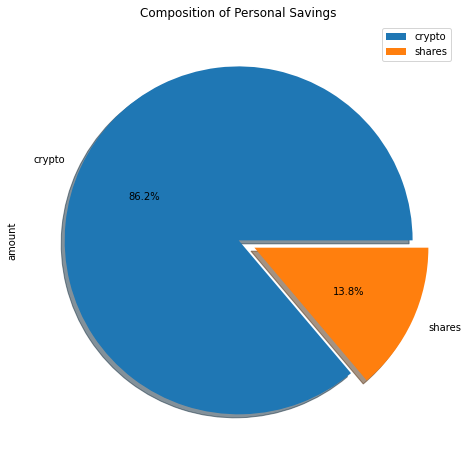

In [131]:
# Plot savings pie chart
df_savings.plot.pie(
    y= 'amount', title= 'Composition of Personal Savings', legend= True,\
    autopct='%1.1f%%', shadow=True, startangle=0,\
    explode = (0, 0.1),\
    figsize = (8, 8)
    )